In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/reforecast'

best_model_combos = [
    ('svr', 'svr'),
    ('lgb', 'svr'),
    ('mlr', 'svr'),
    ('mlr', 'svr'),
    ('mlr', 'svr'),
    ('mlr', 'svr'),
    ('lgb', 'svr')
]


site 1 best model combination : SVR_SVR_MSE
site 2 best model combination : LGB_SVR_MSE
site 4 best model combination : MLR_LGB_MSE
site 5 best model combination : LGB_SVR_MSE
site 6 best model combination : MLR_SVR_MSE
site 7 best model combination : LGB_MLR_MSE
site 8 best model combination : LGB_SVR_MSE

In [ ]:
import numpy as np
import pandas as pd
import os
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

forecast_models = ['svr','lgb','mlr','mlr','mlr','mlr','lgb']
files = []
sites = [1, 2, 4, 5, 6, 7, 8]

for site,forecast_model in zip([1,2,4,5,6,7,8], forecast_models):
  files.append([os.path.join(path + '/result_of_paper/22mon_reforecast_data/', file) for file in os.listdir(path + '/result_of_paper/22mon_reforecast_data/') if file.endswith('.csv') and forecast_model in file and f'{str(site)}' in file][0])

df_list = [pd.read_csv(file) for file in files]

# site 3 제거
fig = go.Figure()

for df, site,forecast_model in zip(df_list, sites, forecast_models):
    data = df[f'error_{forecast_model}'].dropna().mul(-1)
    kde = gaussian_kde(data)
    x = np.linspace(-1.2, 1.2, 200)
    z = kde(x)
    y = np.full_like(x, fill_value=site)

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(width=4),
        name=f"Site {site}"
    ))
for i, (df, site, forecast_model) in enumerate(zip(df_list, sites, forecast_models)):
    data = df[f'error_{forecast_model}'].dropna().mul(-1)
    kde = gaussian_kde(data)
    x = np.linspace(-1.2, 1.2, 200)
    z = kde(x)
    y = np.full_like(x, fill_value=str(site))  # ← 숫자 대신 문자열

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(width=4),
        name=f"Site {site}"
    ))

# y축 카테고리 순서 명시
fig.update_layout(
    scene=dict(
        yaxis=dict(
            type='category',
            categoryorder='array',  # 명시적으로 순서 고정
            categoryarray=[str(s) for s in sorted(sites)],  # 정렬된 순서대로
            title='Site index'
        ),
        xaxis_title='Relative error',
        zaxis_title='Probability density'
    ),
    width=1400,
    height=800,
    scene_camera=dict(
        eye=dict(x=1.2, y=1.5, z=0.7)
    )
)
fig.show()


In [ ]:
df_list[0].columns

Index(['Total solar irradiance (W/m2)', 'Air temperature  (°C) ',
       'Atmosphere (hpa)', 'Power (MW)', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'same_time_mean', 'same_time_std', 'same_time_max',
       'same_time_min', 'same_weekday_mean', 'same_weekday_std',
       'same_weekday_max', 'same_weekday_min', 'overall_mean', 'overall_std',
       'overall_max', 'overall_min', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'diff_15min', 'diff_30min',
       'diff_45min', 'diff_60min', 'diff_75min', 'diff_90min', 'diff_105min',
       'error_svr', 'pred_svr', 'pred_error_mlr', 'pred_error_svr',
       'pred_error_lgb', 'Time', 'reforecasted_PV_mlr', 'reforecasted_PV_svr',
       'reforecasted_PV_lgb'],
      dtype='object')

In [ ]:
df_list[0].columns

Index(['Total solar irradiance (W/m2)', 'Air temperature  (°C) ',
       'Atmosphere (hpa)', 'Power (MW)', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'same_time_mean', 'same_time_std', 'same_time_max',
       'same_time_min', 'same_weekday_mean', 'same_weekday_std',
       'same_weekday_max', 'same_weekday_min', 'overall_mean', 'overall_std',
       'overall_max', 'overall_min', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'diff_15min', 'diff_30min',
       'diff_45min', 'diff_60min', 'diff_75min', 'diff_90min', 'diff_105min',
       'error_svr', 'pred_svr', 'pred_error_mlr', 'pred_error_svr',
       'pred_error_lgb', 'Time', 'reforecasted_PV_mlr', 'reforecasted_PV_svr',
       'reforecasted_PV_lgb'],
      dtype='object')

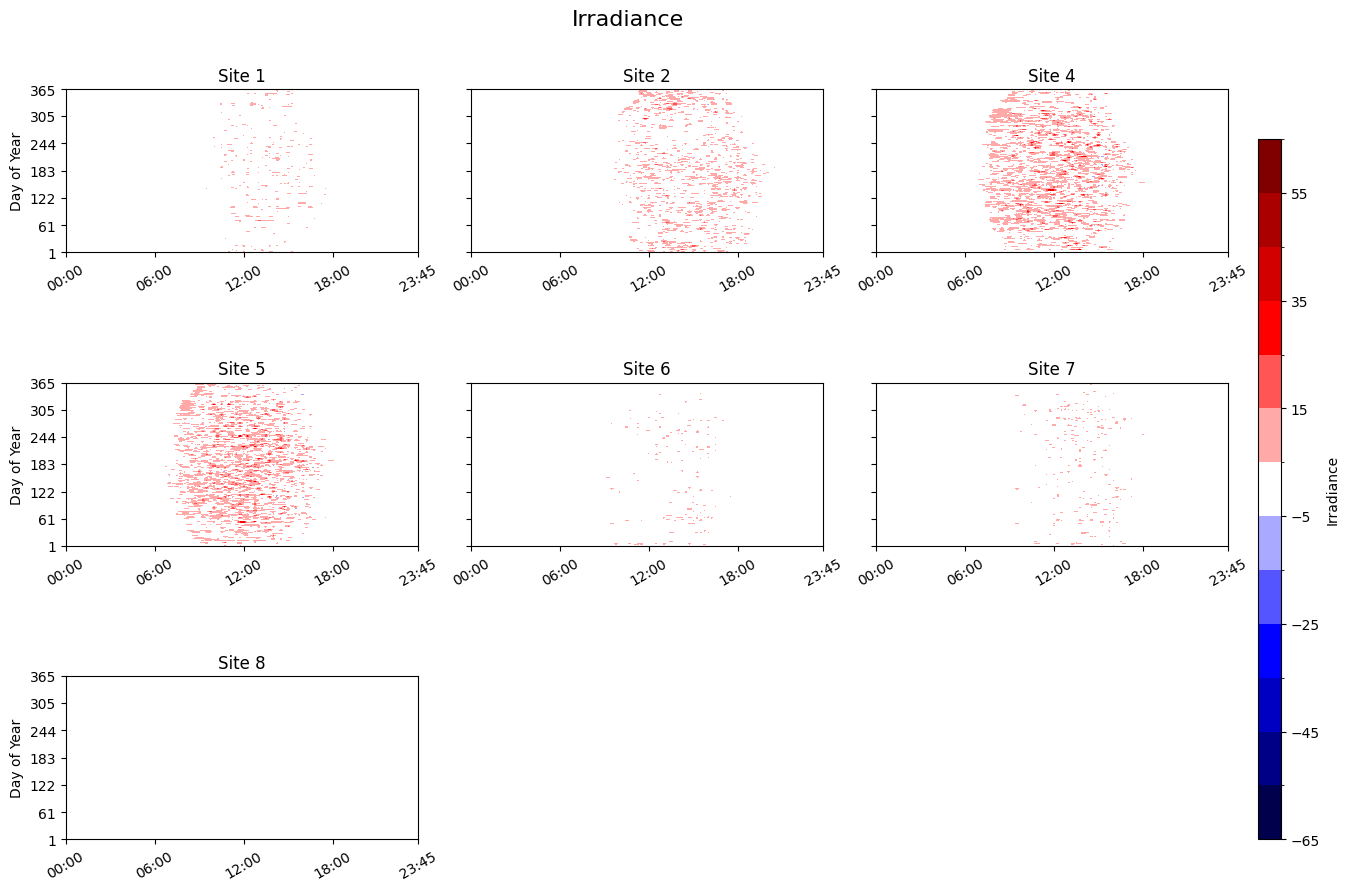

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from matplotlib.colors import BoundaryNorm, ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def process_time(df):
    df['Time'] = pd.to_datetime(df['Time'])
    df['time_index'] = df['Time'].dt.hour * 4 + df['Time'].dt.minute // 15
    df['dayofyear'] = df['Time'].dt.dayofyear
    return df

def smart_round_step(x):
    exp = np.floor(np.log10(x))
    base = 10 ** exp
    for factor in [1, 2, 5, 10]:
        step = base * factor
        if step >= x:
            return step
    return base * 10

all_grid_z = []
mul = -1

forecast_models = ['svr','lgb','mlr','mlr','mlr','mlr','lgb', '_', '_']
for i, site, forecast_model in zip(range(9), [1, 2, 4, 5, 6, 7, 8, '_', '_'], forecast_models):
    if i < len(df_list):
        target = f'error_{forecast_model}'
        df = process_time(df_list[i])
        pivot = df.groupby(['dayofyear', 'time_index'])[target].mean().reset_index()
        residual = pivot[target].mul(mul)  # or residual = pivot[target].mul(-1) 로 실험
        time = pivot['time_index']
        doy = pivot['dayofyear']
        grid_z = griddata(
            points=(time, doy),
            values=residual,
            xi=np.meshgrid(np.linspace(0, 95, 96), np.linspace(1, 365, 365)),
            method='linear',
            fill_value=np.nan
        )
        all_grid_z.append(grid_z)

# ✅ 모든 grid_z 기준으로 고정된 levels 구성
abs_max = max(np.nanmax([np.nanmax(z) for z in all_grid_z]),
              -np.nanmin([np.nanmin(z) for z in all_grid_z]))  # 부호 보존

step = smart_round_step(abs_max / 10)
half_n = int(np.ceil(abs_max / step))
levels = np.arange(-half_n * step - step / 2, (half_n + 1) * step + step / 2, step)

n_colors = len(levels) - 1
colors = plt.cm.seismic(np.linspace(0, 1, n_colors))
colors[n_colors // 2] = [1, 1, 1, 1]  # 중앙은 흰색
cmap = ListedColormap(colors)
norm = BoundaryNorm(levels, ncolors=cmap.N)

# ✅ 본격적으로 그리기 시작
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()


contour = None
for i, site, forecast_model in zip(range(9), [1, 2, 4, 5, 6, 7, 8, '_', '_'], forecast_models):
    ax = axes[i]
    if i < len(df_list):
        target = f'error_{forecast_model}'
        df = process_time(df_list[i])
        pivot = df.groupby(['dayofyear', 'time_index'])[target].mean().reset_index()

        time = pivot['time_index']
        doy = pivot['dayofyear']
        residual = pivot[target].mul(mul)  # ← 또는 안 곱하고 비교할 수 있음

        grid_x, grid_y = np.meshgrid(
            np.linspace(0, 95, 96),
            np.linspace(1, 365, 365)
        )

        grid_z = griddata(
            points=(time, doy),
            values=residual,
            xi=(grid_x, grid_y),
            method='linear',
            fill_value=np.nan
        )

        contour = ax.contourf(grid_x, grid_y, grid_z, levels=levels, cmap=cmap, norm=norm)
        ax.set_title(f'Site {site}', fontsize=12)

        ax.set_xticks([0, 24, 48, 72, 95])
        ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '23:45'], fontsize=10, rotation=30)
        ax.tick_params(labelbottom=True)

        if i % 3 == 0:
            ax.set_ylabel('Day of Year')
        ax.set_yticks([1, 61, 122, 183, 244, 305, 365])
    else:
        ax.axis('off')

# ✅ colorbar 고정
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Irradiance')

fig.suptitle('Irradiance', fontsize=16)
fig.subplots_adjust(top=0.9, bottom=0.15, wspace=0.15, hspace=0.8)
plt.show()


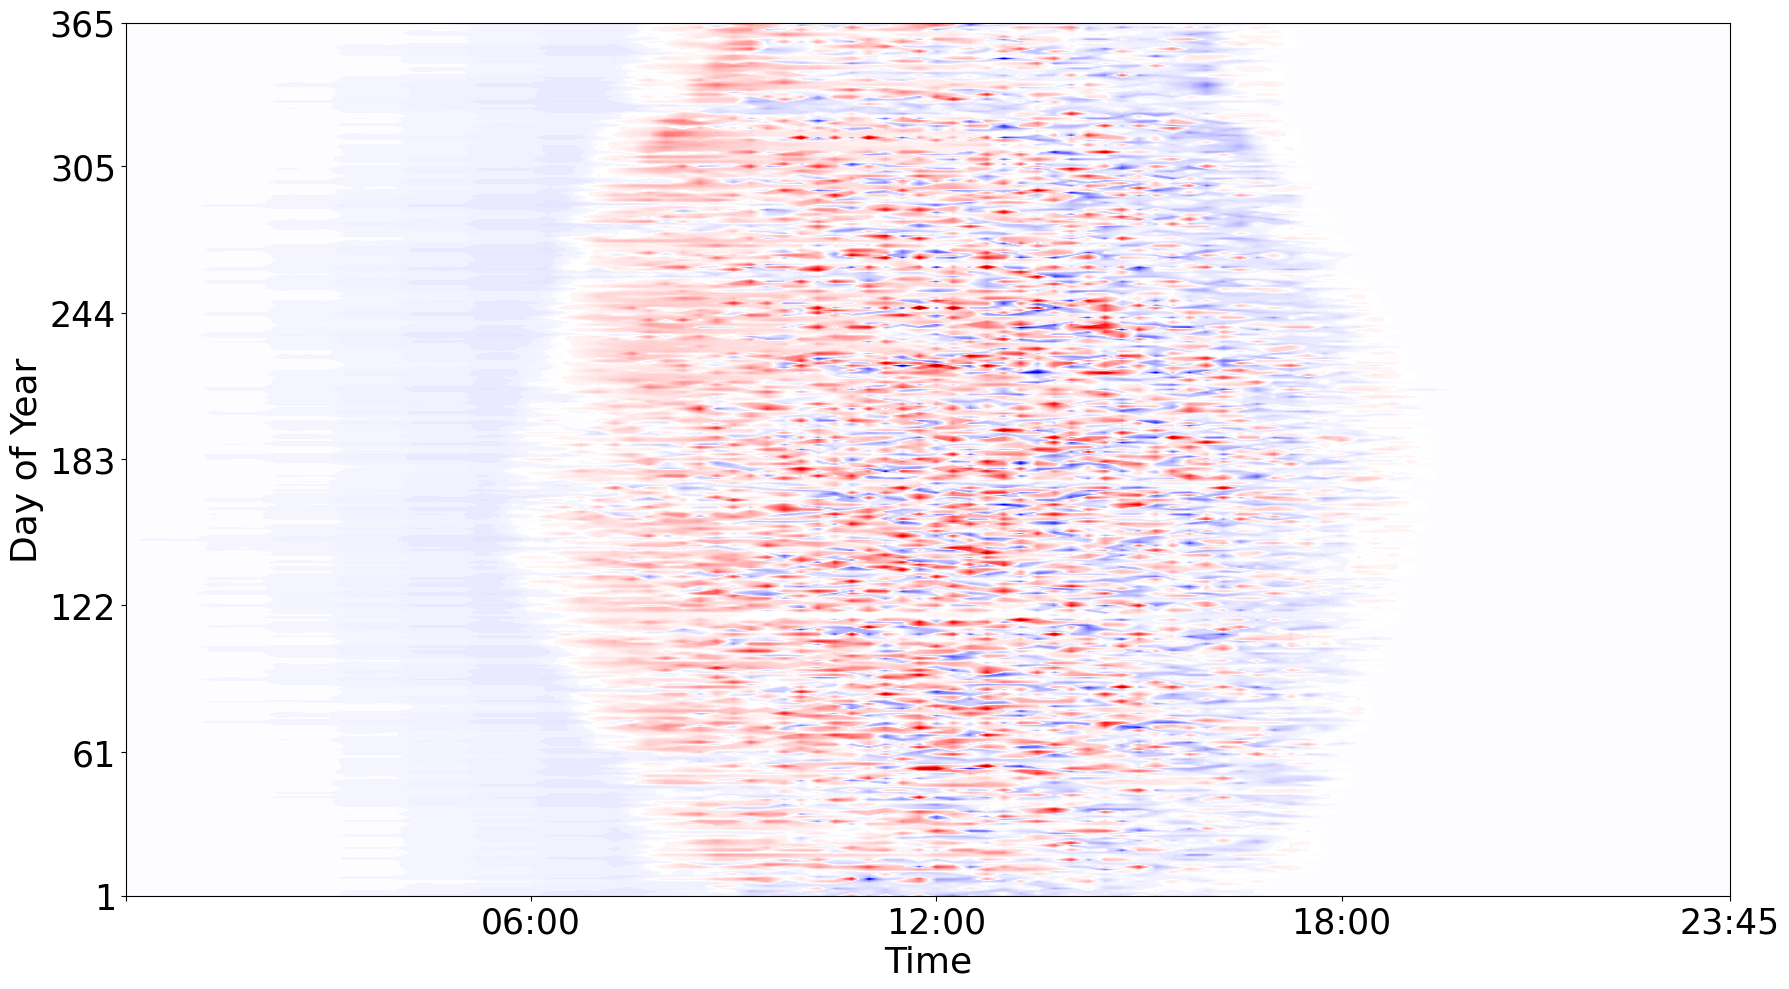

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from matplotlib.colors import BoundaryNorm, ListedColormap

def process_time(df):
    df['Time'] = pd.to_datetime(df['Time'])
    df['time_index'] = df['Time'].dt.hour * 4 + df['Time'].dt.minute // 15
    df['dayofyear'] = df['Time'].dt.dayofyear
    return df

site_idx = 3
forecast_model = forecast_models[site_idx]

target = f'error_{forecast_model}'
df = process_time(df_list[site_idx])
pivot = df.groupby(['dayofyear', 'time_index'])[target].mean().reset_index()

time = pivot['time_index']
doy = pivot['dayofyear']
residual = pivot[target].mul(-1)

grid_x, grid_y = np.meshgrid(np.linspace(0, 95, 96), np.linspace(1, 365, 365))
grid_z = griddata((time, doy), residual, (grid_x, grid_y), method='linear', fill_value=np.nan)

abs_max = np.nanmax(np.abs(grid_z))
step = 0.5
bound = np.ceil(abs_max / step) * step
levels = np.arange(-bound, bound + step, step)

colors = plt.cm.seismic(np.linspace(0, 1, len(levels) - 1))
colors[len(colors) // 2] = [1, 1, 1, 1]
cmap = ListedColormap(colors)
norm = BoundaryNorm(levels, ncolors=cmap.N)

# ▶ 비율 1.8:1
fig, ax = plt.subplots(figsize=(18, 10))

contour = ax.contourf(grid_x, grid_y, grid_z, levels=levels, cmap=cmap, norm=norm)

ax.set_xticks([0, 24, 48, 72, 95])
ax.set_xlabel("Time", fontsize=26)
ax.set_xticklabels(['', '06:00', '12:00', '18:00', '23:45'])
ax.set_yticks([1, 61, 122, 183, 244, 305, 365])
ax.set_ylabel("Day of Year", fontsize=26)
ax.tick_params(axis='both', labelsize=25)

# ▶ 컬러바 없음
plt.tight_layout()
plt.show()
